In [1]:
import os
import cv2    
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras import backend as k
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

plt.style.use('ggplot')

%matplotlib inline

In [5]:
lfw_folder = 'lfw'
import shutil
def flatten_directory(root):
  for folder in os.listdir(root):
    subdir = os.path.join(root, folder)
    if os.path.isdir(subdir):
      for item in os.listdir(subdir):
        src = os.path.join(subdir, item)
        dst = os.path.join(root, item)
        shutil.move(src, dst)      
      os.rmdir(subdir)
flatten_directory('./lfw')

In [6]:
## This part of the code is formed with the help of keras functions thereby allowing to 
##select the features which we want to perform clustering on
##the second part of the code helps in splitting dataset into training, test and validation

class CelebA():

  def __init__(self, main_folder='celeba-dataset/', selected_features=None, drop_features=[]):
    self.main_folder = main_folder
    self.images_folder   = os.path.join(main_folder, 'img_align_celeba/')
    self.attributes_path = os.path.join(main_folder, 'list_attr_celeba.csv')
    self.partition_path  = os.path.join(main_folder, 'list_eval_partition.csv')
    self.selected_features = selected_features
    self.features_name = []
    self.__prepare(drop_features)

  def __prepare(self, drop_features):
 
    if self.selected_features is None:
      self.attributes = pd.read_csv(self.attributes_path)
      self.num_features = 40
    else:
      self.num_features = len(self.selected_features)
      self.selected_features = self.selected_features.copy()
      self.selected_features.append('image_id')
      self.attributes = pd.read_csv(self.attributes_path)[self.selected_features]

    ##Of the 40 attributes, we are performing feature clsuters with only 37 of them. So we are dropping 3 of them here
    for feature in drop_features:
      if feature in self.attributes:
        self.attributes = self.attributes.drop(feature, axis=1)
        self.num_features -= 1
      
    self.attributes.set_index('image_id', inplace=True)
    self.attributes.replace(to_replace=-1, value=0, inplace=True)
    self.attributes['image_id'] = list(self.attributes.index)
  
    self.features_name = list(self.attributes.columns)[:-1]
  
    # load ideal partitioning:
    self.partition = pd.read_csv(self.partition_path)
    self.partition.set_index('image_id', inplace=True)
  
  def split(self, name='training', drop_zero=False):
    '''Returns the ['training', 'validation', 'test'] split of the dataset'''
    # select partition split:
    if name is 'training':
      to_drop = self.partition.where(lambda x: x != 0).dropna()
    elif name is 'validation':
      to_drop = self.partition.where(lambda x: x != 1).dropna()
    elif name is 'test':  # test
      to_drop = self.partition.where(lambda x: x != 2).dropna()
    else:
      raise ValueError('CelebA.split() => `name` must be one of [training, validation, test]')

    partition = self.partition.drop(index=to_drop.index)
      
    # join attributes with selected partition:
    joint = partition.join(self.attributes, how='inner').drop('partition', axis=1)

    if drop_zero is True:
      # select rows with all zeros values
      return joint.loc[(joint[self.features_name] == 1).any(axis=1)]
    elif 0 <= drop_zero <= 1:
      zero = joint.loc[(joint[self.features_name] == 0).all(axis=1)]
      zero = zero.sample(frac=drop_zero)
      return joint.drop(index=zero.index)

    return joint

In [7]:
celeba = CelebA(drop_features=[
    'Attractive',
    'Pale_Skin',
    'Blurry',
])

In [14]:
save_path = 'C:/Users/Aashika/'   ##Provide the path in which the dataset is saved.  
import tensorflow
from tensorflow.keras.models import Model 
model = tensorflow.keras.models.load_model(f"{save_path}MobileNetV2-0.92.hdf5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
img_size = 224 
# default is 224
IMG_W = img_size
IMG_H = img_size
IMG_SHAPE = (IMG_H, IMG_W, 3)
TARGET_SIZE = (IMG_H, IMG_W)

In [16]:
dict_feature_name_to_index = { name: i for i, name in enumerate(celeba.features_name) }
dict_index_to_feature_name = { v: k for k, v in dict_feature_name_to_index.items() }
## This part of the code is used to convert the feature names into indices
def features_to_indexes(features_name):
indexes = []
  
  for name in features_name:
    indexes.append(dict_feature_name_to_index[name])
  
  return indexes

## This part of the code is used to convert the feature indices into feature names, returns the feature names.
def indexes_to_features(feature_indexes):
  
  features_name = []
  
  for index in feature_indexes:
    features_name.append(dict_index_to_feature_name[index])
  
  return features_name

In [17]:

def image_paths_from_folder(folder, amount=-1):
assert(folder is not None)
  
paths = []
  count = 0
  
  for file in os.listdir(folder):
    # select only images
    if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
        paths.append(os.path.join(folder, file))
          count += 1      
    if count == amount:
        break
      
      return paths


##This step is to pre process the images into required size and load them to an array
def load_reshape_img(fname, shape):
      img = load_img(fname, target_size=shape)
          x = img_to_array(img) / 255.0
              x = x.reshape(x.shape)
                  return x


def infere_labels(model, paths):

  '''
  '''
  assert(model is not None)
  
  image_batch = []
  
  for path in paths:
    img = load_reshape_img(path, TARGET_SIZE)
    image_batch.append(img)
    
  
  preds = model.predict(np.array(image_batch), batch_size=64, verbose=1)
  
  
  preds = np.round(preds).astype('int')  
  return preds

##The pandas dataframe is used to organize the image feature labels, returns the df indexed by image_path
def dataframe_from_folder_or_labels(features_name, folder, labels=None, model=None, amount=-1):
  
  paths = image_paths_from_folder(folder, amount)
  labels = labels or infere_labels(model, paths)
  indexes = features_to_indexes(features_name)
  
  df = pd.DataFrame()
  df['image_path'] = paths
  df.set_index('image_path', inplace=True)
  
  
  for i, name in enumerate(features_name):
    column = []
    
    for j, features in enumerate(labels):
      column.append(features[indexes[i]])
    df[name] = column
  

  img_features = []
  for features in labels:
    features_ = []
    
    for i, name in enumerate(features_name):
      features_.append(features[indexes[i]])
    img_features.append(features_)
  
  
  df['features'] = img_features
  
  return df

In [18]:
##The features are given as an input in this array, these are converted into their correspnding indices.
chosen_features = [
   'Wearing_Lipstick',
   'Smiling',               
   'No_Beard',             
   'Heavy_Makeup',
   'Bald',
   'Male',           
   'Young',
   'Eyeglasses',
   'Blond_Hair',
   'Wearing_Hat'
]

chose_features_indexes = features_to_indexes(chosen_features)

print(f"selected features: {chosen_features}")
print(f"features indexes: {chose_features_indexes}")

selected featrues: ['Wearing_Lipstick', 'Smiling', 'No_Beard', 'Heavy_Makeup', 'Bald', 'Male', 'Young', 'Eyeglasses', 'Blond_Hair', 'Wearing_Hat']
features indexes: [33, 28, 22, 16, 3, 18, 36, 13, 8, 32]


In [19]:
##Vectors of image faetures are taken to compute the loss function
celeba_df = dataframe_from_folder_or_labels(chosen_features, celeba.images_folder,  model=model, amount=2000)
celeba_df = celeba_df.sample(400, random_state=51)
celeba_df.head()

2000/2000 [==============================] - 218s 109ms/sample


Wearing_Lipstick  Smiling  \
image_path                                                              
celeba-dataset/img_align_celeba/001618.jpg                 0        0   
celeba-dataset/img_align_celeba/000886.jpg                 0        1   
celeba-dataset/img_align_celeba/000434.jpg                 0        0   
celeba-dataset/img_align_celeba/000189.jpg                 0        1   
celeba-dataset/img_align_celeba/001265.jpg                 1        0   

                                            No_Beard  Heavy_Makeup  Bald  \
image_path                                                                 
celeba-dataset/img_align_celeba/001618.jpg         1             0     0   
celeba-dataset/img_align_celeba/000886.jpg         0             0     0   
celeba-dataset/img_align_celeba/000434.jpg         1             0     0   
celeba-dataset/img_align_celeba/000189.jpg         1             0     0   
celeba-dataset/img_align_celeba/001265.jpg         1             0     0   

                                            Male  Young  Eyeglasses  \
image_path                                                            
celeba-dataset/img_align_celeba/001618.jpg     0      1           0   
celeba-dataset/img_align_celeba/000886.jpg     1      1           0   
celeba-dataset/img_align_celeba/000434.jpg     1      1           0   
celeba-dataset/img_align_celeba/000189.jpg     0      1           0   
celeba-dataset/img_align_celeba/001265.jpg     0      1           0   

                                            Blond_Hair  Wearing_Hat  \
image_path                                                            
celeba-dataset/img_align_celeba/001618.jpg           0            0   
celeba-dataset/img_align_celeba/000886.jpg           0            0   
celeba-dataset/img_align_celeba/000434.jpg           0            0   
celeba-dataset/img_align_celeba/000189.jpg           0            0   
celeba-dataset/img_align_celeba/001265.jpg           1            0   

                                                                  features  
image_path                                                                  
celeba-dataset/img_align_celeba/001618.jpg  [0, 0, 1, 0, 0, 0, 1, 0, 0, 0]  
celeba-dataset/img_align_celeba/000886.jpg  [0, 1, 0, 0, 0, 1, 1, 0, 0, 0]  
celeba-dataset/img_align_celeba/000434.jpg  [0, 0, 1, 0, 0, 1, 1, 0, 0, 0]  
celeba-dataset/img_align_celeba/000189.jpg  [0, 1, 1, 0, 0, 0, 1, 0, 0, 0]  
celeba-dataset/img_align_celeba/001265.jpg  [1, 0, 1, 0, 0, 0, 1, 0, 1, 0]

In [20]:
from sklearn.cluster import KMeans

from math import sqrt


def score(method, features):
  print(f'Score with {n_clusters} clusters is {-method.inertia_}')
  
def silhouette(features, labels):
  print(f'silhouette_score: {silhouette_score(features, labels)} for {n_clusters} clusters')

  
def resize(image, shape):
        return cv2.resize(image, shape)

def imread(path, shape=None):
      img = cv2.imread(path, cv2.IMREAD_COLOR)
  
  if shape is not None:
    img = resize(img, shape)
    
      return img
##All the cluster-labels ate converted into a dictionary of indices 
def labels_to_indices(labels):

    indices  = dict()
  
  for cluster_id in set(labels):
    indices[cluster_id] = []
  
  for i, label in enumerate(labels):
    indices[label].append(i)
  
  return indices

In [21]:
##Keras has got an inbuilt class to perform clustering which is employed here. A gew changes wth respect to the K-Means is used
#to return the final set of clustering value.

class Cluster:
 
  def __init__(self, k, features, paths):
    if len(features) != len(paths):
      raise ValueError("Size of [features] and [paths] parameters must be the same!")
    
    self.k = k
    self.features = features
    self.paths = paths
    self.size = len(paths)
    self.image = None
    self.eigenface = None
  
  def get_image(self, img_size=200, rows=None, cols=None):
  
    if self.image is not None:
      return self.image
    
    if (rows is None) or (cols is None):
      rows = int(sqrt(self.size))
      cols = rows
      
    h, w = img_size, img_size
    image = np.zeros(shape=(h * rows, h * cols, 3), dtype=np.uint8)
      
    k = 0
    for i in range(rows):
      r = i * h
      for j in range(cols):
        c = j * w
        img = imread(self.paths[k], shape=(w, h))
        image[r:r+w, c:c+w] = img
        
        k = k + 1
        if k > self.size:
          break

    self.image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return self.image
  
  def plot(self, img_size=200, dpi=100, rows=None, cols=None):

    image = self.get_image(img_size, rows, cols)
    
    plt.figure(dpi=dpi)
    plt.imshow(image)
    plt.grid(False)
    
  def __len__(self):
    return self.size
      
  def features_frequency(self):
    
    num = len(self.features[0])
    frequencies = np.zeros(num)
      
    for features in self.features:
        frequencies += features
      
    return np.round(frequencies / self.size, 2)



class Clustering:
  
  def __init__(self, Method): 
    self.method = Method
    self.result = None
    self.features = None
    self.labels = None
    self.num_clusters = None
  
  def fit(self, df, features_weights=None, verbose=False):

    clusters = []
    features = df['features'].to_list()
    features = np.array(features)
    
    if features_weights is None:
        features_weights = np.ones(features.shape, dtype=np.float32)
    
    # fit features (viewed as n-dimensional points)
    result = self.method.fit(features * features_weights)
    
    # get clustering info
    labels = result.labels_
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_amount = list(labels).count(-1)  # count the occurrencies of '-1'
    
    # save as last fit
    self.result = result
    self.labels = labels
    self.features = features
    self.num_clusters = num_clusters
    
    if verbose is True:
      print(f'Estimated number of clusters: {num_clusters}')
      print(f'Estimated number of noise points: {noise_amount}')
    
    # for every cluster, get the indexes of the belonging samples
    indices = labels_to_indices(labels)
    
# build Cluster istances
    for k in range(num_clusters):
# for every cluster k find the corresponding image paths and features
      df_slice = df.iloc[indices[k]]
      paths = list(df_slice.index)
      features = list(df_slice['features'].values)

      clusters.append(Cluster(k, features, paths))
    
    return clusters
##This function is used to calculate the clustering evaluation based on the input k value  
  def evaluate(self):
  
    if self.result is None:
      raise ValueError("Fit data before evaluation!")
      
    return silhouette_score(self.features, self.labels)
  
  def plot(clusters, rows, cols, dpi=100):
    '''Shows the given clusters.
        - rows: number of rows in the subplot.
        - cols: nuber of columns in the subplot.
        - dpi: plt.figure resolution
    '''
    plt.figure(figsize=(20, 20), dpi=dpi)
    
    for i, cluster in enumerate(clusters):
      image = cluster.get_image()
      
      plt.subplot(rows, cols, i + 1)
      plt.title(f"Cluster {cluster.k}")
      plt.imshow(image)
      plt.grid(False)
      plt.tight_layout()
    
    _ = plt.show()


In [23]:
## The k value we chose is 16. This can be any random number.
## The clustering score when close to 1 is considered to be perfect.

num_clusters = 16
kmeans = KMeans(n_clusters=num_clusters)
kmeans = Clustering(kmeans)

clusters = kmeans.fit(celeba_df, verbose=True)

print(f"Clustering score: {kmeans.evaluate()}")

Estimated number of clusters: 16
Estimated number of noise points: 0
Clustering score: 0.7099737749545949


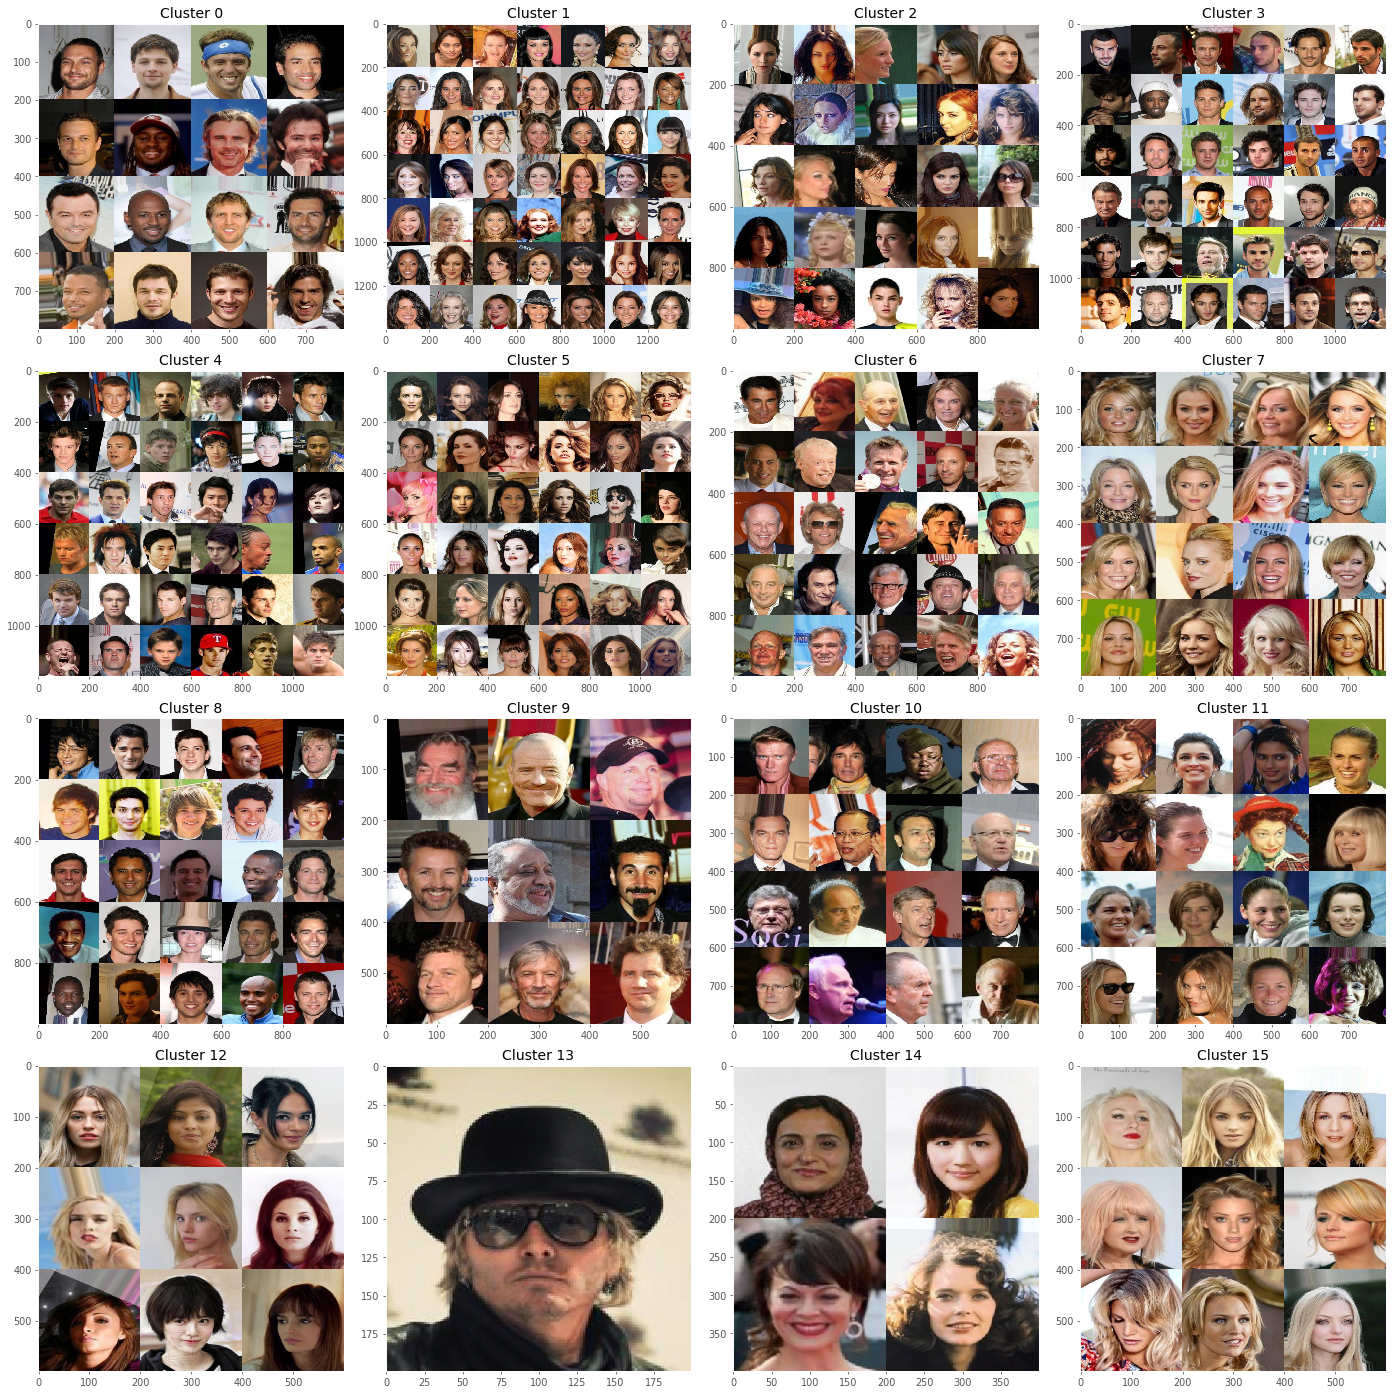

In [24]:
##This is used to plot the clusters in the desired number of rows and columns
Clustering.plot(clusters, rows=4, cols=4, dpi=70)